In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
import torch.nn as nn

from copy import deepcopy

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Data exploration

In [3]:
df = pd.read_csv("/kaggle/input/phishing-email-dataset/phishing_email.csv")

In [4]:
df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


# Tokenization

In [6]:
tokenizer = get_tokenizer("basic_english")

def yield_tokenizer(batch):
    for txt, _ in batch:
        yield tokenizer(txt)
        
vocab = build_vocab_from_iterator(yield_tokenizer(df.values), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Training hyper-parameters

In [14]:
EPOCHS = 20
LR = 0.1
GAMMA = 0.1
STEP = 10
VOCAB_SIZE = len(vocab)
EM_SIZE = 64
OUT_SIZE = 2
BATCH = 128

# Text pipeline

In [8]:
text_pipeline = lambda x: vocab(tokenizer(x))

# Data preprocessing pipeline

In [23]:
def collate_batch(x):
    texts, labels, offsets = [], [], [0]
    for txt, label in x:
        text = torch.tensor(text_pipeline(txt), dtype=torch.int64)
        labels += [label]
        texts += [text]
        offsets += [text.size(0)]
    texts = torch.cat(texts)
    labels = torch.tensor(labels, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    
    if torch.cuda.is_available():
        texts, labels, offsets = texts.cuda(), labels.cuda(), offsets.cuda()
        
    return texts, labels, offsets

# 80/20 split for training and validation correspondingly and 50/50 validation split into validation and testing

In [24]:
train, validation = train_test_split(df.values, random_state=42, test_size=0.2)
val, test = train_test_split(validation, random_state=42, test_size=0.5)

# DataLoader built

In [25]:
train_dl = DataLoader(train, batch_size=BATCH, shuffle=True, collate_fn=collate_batch)
val_dl = DataLoader(val, batch_size=BATCH, shuffle=False, collate_fn=collate_batch)

# Training architecture with skip-connections

In [26]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, downscale=True):
        super(Block, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.norm = nn.BatchNorm1d(out_features)
        self.relu = nn.ReLU()
        self.scale = downscale
        
        
    def forward(self, x):
        y = self.linear(x)
        y = self.norm(y)
        y = self.relu(y)
        if self.scale:
            return y
        y = torch.add(y, x)
        return y

class PhishingDetector(nn.Module):
    def __init__(self, vocab_size, em_size, out_size):
        super(PhishingDetector, self).__init__()
        self.embed = nn.EmbeddingBag(vocab_size, em_size)
        self.layers = nn.Sequential(Block(em_size, 128),
                                   Block(128, 128, False),
                                    Block(128, 128, False),
                                   Block(128, 64),
                                   Block(64, 64, False),
                                   Block(64, 64, False))
        self.fc = nn.Linear(64, out_size)
        
    def forward(self, x, off):
        x = self.embed(x, off)
        x = self.layers(x)
        x = self.fc(x)
        return nn.functional.softmax(x, dim=1)

# Training device

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Training parameters

In [28]:
model = PhishingDetector(VOCAB_SIZE, EM_SIZE, OUT_SIZE)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

# Training model

In [29]:
best_model = deepcopy(model)

best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    acc = 0
    total = 0
    
    for text, label, offset in train_dl:
        optimizer.zero_grad()
        
        out = model(text, offset)
        loss = criterion(out, label)
        diff += loss.item()
        acc += (out.argmax(1) == label).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    acc = 0
    total = 0
    
    with torch.no_grad():
        for text, label, offset in train_dl:
            out = model(text, offset)
            loss = criterion(out, label)
            diff += loss.item()
            acc += (out.argmax(1) == label).sum().item()
            total += out.size(0)
    
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] >= best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    print("Epoch {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                   train_acc[-1], val_loss[-1],
                                                                   val_acc[-1]))
    
    scheduler.step()

Epoch 1 train loss 0.003992549488835243 acc 0.7905831363278172 val loss 0.00361303077879592 acc 0.8450778929502334
Epoch 2 train loss 0.0036030473792640384 acc 0.8448657331636055 val loss 0.003403380815333335 acc 0.8750075771352367
Epoch 3 train loss 0.0034588526735892834 acc 0.8660362490149724 val loss 0.0033214272203073722 acc 0.8859186518760986
Epoch 4 train loss 0.0033642678333750896 acc 0.8789325331878524 val loss 0.0032552338550833203 acc 0.8940110323089047
Epoch 5 train loss 0.0032881727129276967 acc 0.8890858944050434 val loss 0.003203313109650282 acc 0.9010426138085712
Epoch 6 train loss 0.003233201546604549 acc 0.8964357155846517 val loss 0.00313801135721731 acc 0.9101806389040431
Epoch 7 train loss 0.0031959067709685716 acc 0.901103230890465 val loss 0.0030765995435652 acc 0.9178941625750137
Epoch 8 train loss 0.0031391752935390933 acc 0.9103624901497241 val loss 0.003023484457010297 acc 0.9262441656058678
Epoch 9 train loss 0.003108892622099231 acc 0.9133478814329878 val lo

# Training performance log

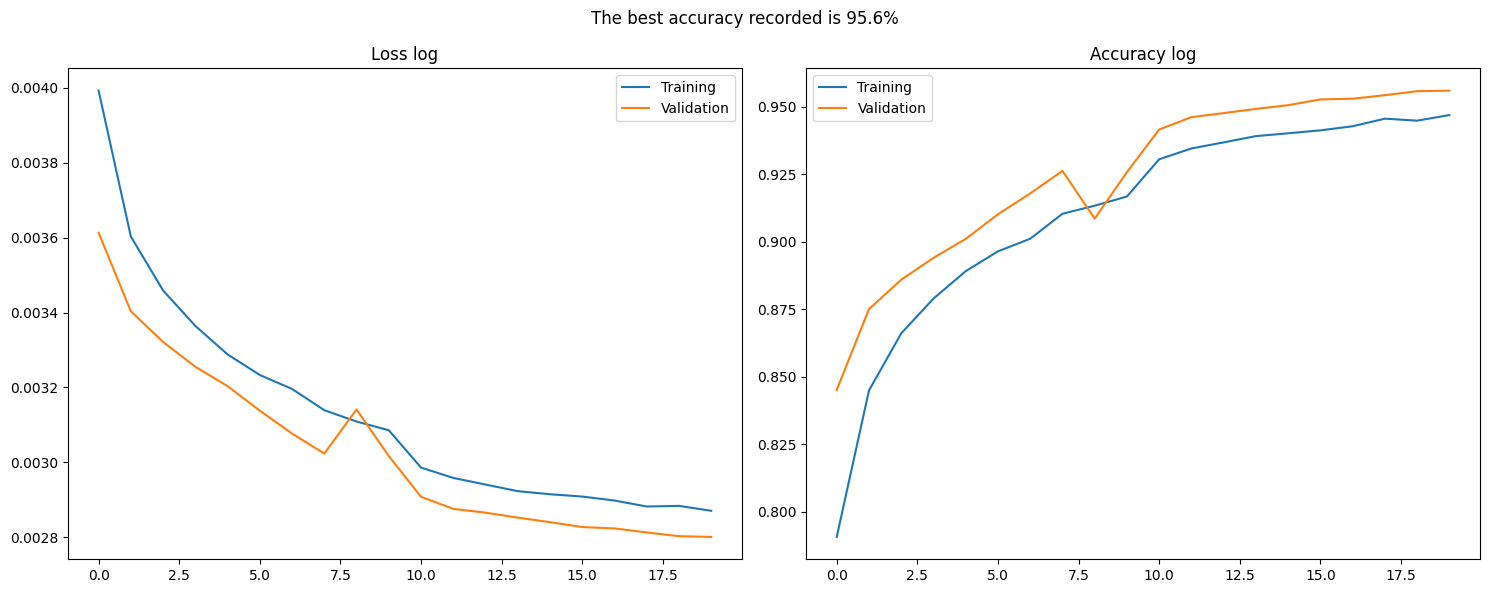

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

index = 0

axes[index].plot(train_loss, label="Training")
axes[index].plot(val_loss, label="Validation")
axes[index].legend()
axes[index].set_xlabel("")
axes[index].set_ylabel("")
axes[index].set_title("Loss log")

index += 1

axes[index].plot(train_acc, label="Training")
axes[index].plot(val_acc, label="Validation")
axes[index].legend()
axes[index].set_xlabel("")
axes[index].set_ylabel("")
axes[index].set_title("Accuracy log")

plt.suptitle("The best accuracy recorded is {}%".format(round(best_acc*100, 2)))

plt.tight_layout()
plt.show()

# Prediction pipeline

In [31]:
def predict(text):
    text = torch.cat([torch.tensor(text_pipeline(text))])
    offset = torch.tensor([0])
    
    if torch.cuda.is_available():
        text, offset = text.cuda(), offset.cuda()
        
    best_model.eval()
    with torch.no_grad():
        out = model(text, offset)
    
    index = out.argmax(1).item()
    
    return index, out[0][index].item()

# Predicting test values

In [32]:
pred = []
proba = []
truth = []

for i in range(test.shape[0]):
    label, conf = predict(test[i, 0])
    pred += [label]
    proba += [conf]
    truth += [test[i, 1]]

# Evaluation metrics of predicted test results

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      3966
           1       0.89      0.88      0.88      4283

    accuracy                           0.88      8249
   macro avg       0.88      0.88      0.88      8249
weighted avg       0.88      0.88      0.88      8249



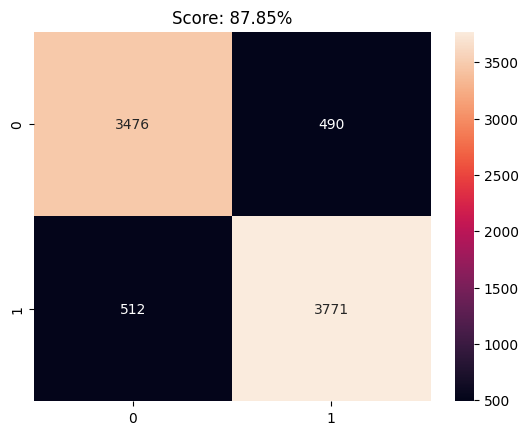

In [33]:
score = accuracy_score(pred, truth)
cm = confusion_matrix(pred, truth)
report = classification_report(pred, truth)

print(report)

sns.heatmap(cm, annot=True, fmt='d')
plt.title("Score: {}%".format(round(score*100, 2)))
plt.show()

# Probabilities that email is phishing or not phishing

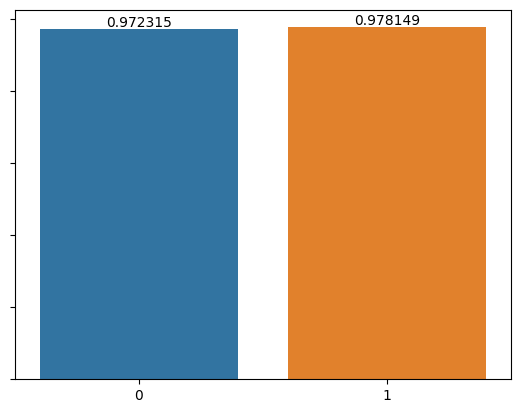

In [35]:
dd = pd.DataFrame({"scores": pred, "probas": proba})
grouped = dd.groupby("scores")
mean = grouped["probas"].mean()

fig, axes = plt.subplots()
sns.barplot(x=mean.index, y=mean, ax=axes)

for container in axes.containers:
    axes.bar_label(container)
axes.set_yticklabels(())
axes.set_ylabel("")
axes.set_xlabel("")
plt.show()